# Dhruv Rana #

In [93]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings

warnings. filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [94]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50 = resnet50.eval().to(device)

Using cache found in C:\Users\dhruv/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\dhruv/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


In [95]:
transform = transforms.Compose([
 transforms.ToTensor(),                     #[1]
 transforms.Normalize(                      #[2]
 mean=[0.5, 0.5, 0.5],                      #[3]
 std=[0.5, 0.5, 0.5]                        #[4]
 )])

In [96]:
img = Image.open('golfcart1.jpg')
img_t = transform(img)
batch = torch.unsqueeze(img_t, 0).to(device)

sample 0: [('golfcart, golf cart', '70.1%'), ('forklift', '0.6%'), ('lawn mower, mower', '0.1%'), ('beaker', '0.1%'), ('balloon', '0.1%')]


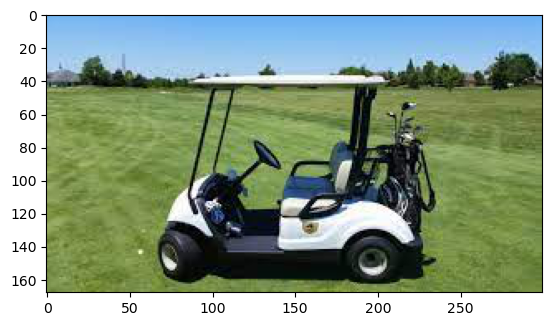

In [97]:
with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(batch), dim=1)


plt.imshow(img)
plt.show()
results = utils.pick_n_best(predictions=output, n=5)